In [1]:
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
from torch.optim import SGD, Adam
from torch.nn import CrossEntropyLoss, MSELoss

# from pennylane import NesterovMomentumOptimizer
from qcnn.qcnn import QCNN

from qcnn.ml.data import Data, BinaryData
from qcnn.ml.optimize import Optimizer
from qcnn.ml.data import image_transform, baseline_image_transform
from qcnn.experiment import Experiment
from qcnn.cnn import CNN

from pathlib import Path
from qcnn.file import save_dataframe_as_csv

from qcnn.quantum.operation.ansatz import ConvolutionAltAnsatz as Ansatz
# from qcnn.quantum.operation.ansatz import BaselineAnsatz as Ansatz

In [2]:
# Meta parameters
name = "gvybuhnij"
path = Path(f"results/{name}")
num_trials = 10
silent = False
is_quantum = True

# Ansatz parameters
dims = (28, 28)
num_layers = 5

In [3]:
# Create model
cls = QCNN if is_quantum else CNN
data = BinaryData(FashionMNIST, image_transform(dims, flatten=is_quantum), batch_size=(4, 1000))
# optimizer = Optimizer(SGD, lr=0.01, momentum=0.9, nesterov=True)
optimizer = Optimizer(Adam)
loss = CrossEntropyLoss()
epoch = 1
model = cls.with_logging(data, optimizer, loss, epoch=epoch)

# Log circuit ID
model.logger.info(f"Circuit ID: {name}")

# Save circuit drawing
if is_quantum:
    model.ansatz = Ansatz.from_dims(dims, num_layers=num_layers)
    filename = path.with_stem(f"{name}_circuit").with_suffix(".png")
    model.ansatz.draw(filename=filename, decompose=True)

2023-06-21 11:41:18,049: (qcnn) Circuit ID: gvybuhnij


In [ ]:
# Run experiment
experiment = Experiment(model, num_trials, results_schema=["accuracy"])

args = (Ansatz,) if is_quantum else ()
results = experiment(*args, dims, num_layers=num_layers, silent=silent)

2023-06-21 10:55:31,208: (qcnn_trial_0) Number of Parameters: 39
2023-06-21 11:18:04,509: (qcnn_trial_0) Accuracy: 79.250%
2023-06-21 11:18:04,539: (qcnn_trial_1) Number of Parameters: 39
2023-06-21 11:39:33,482: (qcnn_trial_1) Accuracy: 79.400%
2023-06-21 11:39:33,514: (qcnn_trial_2) Number of Parameters: 39


In [ ]:
# Save and print accuracy results
save_dataframe_as_csv(path.with_suffix(".csv"), results)
acc = results["accuracy"]
print(acc.median(), acc.mean(), acc.std())

0.9130000174045563 0.9016000092029571 0.04533872254223494


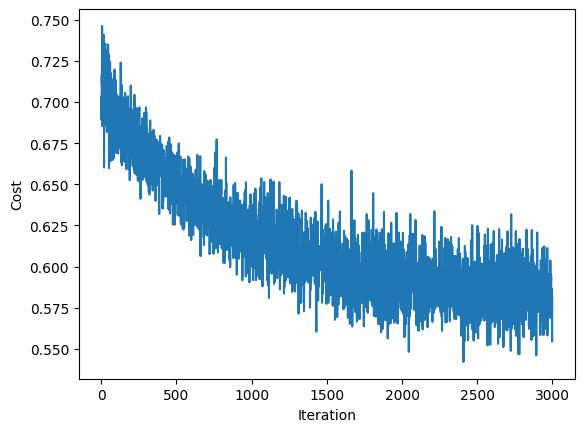

In [ ]:
# Save aggregated loss history figure
(fig,) = experiment.draw(path.with_suffix(".png"))

Variables to consider:
- __batch, epoch__
- Operation on "ancilla" qubits (pre, post, none)
- Filter Ansatz
- Fully-connected Ansatz
- Which qubits to apply Fully-connected
- Which qubits to measure